In [2]:
import matplotlib.pyplot as plt
from numpy import pi, linspace
from numpy.random import normal

In [3]:
import os
import sys
import numpy
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

import matplotlib.pyplot as plt
from IPython import display
from astropy.table import Table,vstack
from desiutil.log import get_logger, DEBUG
from desidiff.src.group_tiles import *
from desidiff.src.dates_to_process import *
from desidiff.src.coadd import *
from desidiff.src.scores import *
from desidiff.src.ContinuumFitFilter_desidiff import *
import requests
from timedomain.sp_utils import SkyPortal as sp
import datetime
from astropy.time import Time

In [4]:
def Lorentz(x,gamma, x0, A):
    L = A*(1/pi)*0.5*gamma/((x-x0)**2 + (0.5*gamma)**2)
    return L

In [5]:
def continuum(m,x,b):
    cont = m*x + b
    return cont

In [6]:
r = linspace(3000,10000,8000)

In [7]:
spec = Lorentz(r, 10, 6562, 5000) + Lorentz(r,10,5007,4000) + Lorentz(r,10, 4852,3500) + Lorentz(r,50, 3835,2500)
# spec = [normal(i, 0.5) for i in spec]

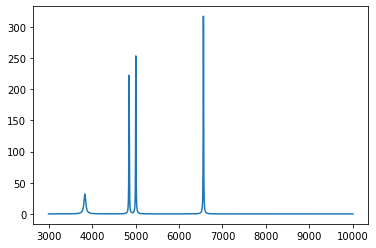

In [8]:
plt.plot(r,spec)
plt.show()

In [9]:
perres_filter = perconv_SN(, spec,difivar,difmask)

SyntaxError: invalid syntax (<ipython-input-9-9ed4285bdb08>, line 1)

In [10]:
%matplotlib inline
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

import matplotlib.pyplot as plt
from IPython import display
from astropy.table import Table,vstack
from desiutil.log import get_logger, DEBUG
from desidiff.src.group_tiles import *
from desidiff.src.dates_to_process import *
from desidiff.src.coadd import *
from desidiff.src.scores import *
from desidiff.src.ContinuumFitFilter_desidiff import *
import requests
from timedomain.sp_utils import SkyPortal as sp
import datetime
from astropy.time import Time
date=20210606
tile_petal,group_tid,group_tp, group_night =getMatchedTileid(date)
#Set non-default plot size 
plt.rcParams["figure.figsize"] = (20,6)

#SkyPortal token:
secret_file = "/global/cfs/cdirs/desi/science/td/secrets/desidiff_sp.txt"
with open(secret_file, 'r') as file:
    token = file.read().replace('\n', '')
headers = {'Authorization': f'token {token}'}

filter_name = 'DESIDIFF'
lminb=3700.
lminr=5800.
lmaxr=7580.
lmaxz=9100.

# tile_petal contain subsets of tile/petals whose RA/DEC targets are not contained in other tile/petals from that night
for tps in tile_petal:
    # Check to see if this tile/petal has nothing to subtract.  Skip's IO if this is the case
    if hasNothingToProcess(tps,group_tid,group_tp,group_night):
        continue
    
    # cache spectra to minimize IO
    spectra_list=dict()
    zbest_list = []
    target_list=[]
    ra_dec_list = []
    for tp in tps:
        filename =  f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/{tp[0]}/{date}/spectra-{tp[1]}-{tp[0]}-thru{date}.fits"
        spectra_list[(tp[0],tp[1])]=read_spectra(filename)
        #To get RA/DEC info for the object
        ra_dec_list.append(Table.read(filename, format='fits',hdu=1, memmap=True)['TARGETID','TARGET_RA', 'TARGET_DEC'])
        zbest = filename.replace('spectra','zbest')
        z = Table.read(zbest, format='fits',hdu=1, memmap=True)['TARGETID','Z','ZERR','ZWARN','SPECTYPE']
        zbest_list.append(z)
    z = vstack(zbest_list)
    ra_dec = vstack(ra_dec_list)
    

    count=0
    # loop over all unique RA/DEC pairs from that night
    for tid, tp, night in zip(group_tid,group_tp,group_night):
        # if this RA/DEC is not in thie tile_petal combination than skip
        if tp[0] not in tps:
            continue
        
        # Eliminate those with no reference night here
        if len(night) == 1:
            continue

        # Obtain METAINFORMATION for this RA/DEC
        #Stores a tuple = (TARGETID, Z, ZERR,ZWARN, SPECTYPE)
        z_data = []
        ra_dec_data = []
        for t in tid:
            tid_ind = list(z['TARGETID']).index(t)
            ra_dec_ind = list(ra_dec['TARGETID']).index(t)
            z_data.append((t, z[tid_ind]['Z'], z[tid_ind]['ZERR'], z[tid_ind]['ZWARN'], z[tid_ind]['SPECTYPE']))
            ra_dec_data.append((t, ra_dec[ra_dec_ind]['TARGET_RA'], ra_dec[ra_dec_ind]['TARGET_DEC']))
        redshift = z_data[0][1] #it seems each set only has one value
        spectype = z_data[0][-1]
        
        # Proceed with a subtraction for this object
        
        # The coadds of the new and reference are constructed from all spectra with all targetid's in tid and all
        # tile/petal combinations in tp, which are cached above
        
        newSpectra=[]
        refSpectra=[]
        for tile,plate in tp:
            spec = spectra_list[(tile,plate)]

            idx = numpy.in1d(night, date)
            ref_night = night[~idx]
            
            newSpectra.append(spec.select(nights=date, targets = tid))
            
            """
            There is a variable night that has all the nights associated with this RA/DEC
            derive the ref_night from that
            """
            
            refSpectra.append(spec.select(nights=ref_night, targets = tid))       
         
        
        newflux, newivar, newwave, newmask = coadd(newSpectra)
        refflux, refivar, refwave, refmask = coadd(refSpectra)

        # renormalize spectra to match each other
        # There is a significant background of spectra that have the same shape but different fluxes
        # This seems to be related to mistaken coordinates of bright sources
        norm = normalization(newflux,newmask, refflux,refmask)

        for key in newflux.keys():
            newflux[key]=newflux[key]/norm
            newivar[key]=newivar[key]*norm**2        
        
        difflux, difivar, difmask, difwave = dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"])
        
        difflux = {key: newflux[key] - refflux[key]
                       for key in newflux.keys()}
        difivar = {key: 1./(1./newivar[key] + 1./refivar[key])
                       for key in newivar.keys()}
        difmask = {key: newmask[key] + refmask[key]
                       for key in newmask.keys()}
        difwave = dict(newwave)
        
        print(difwave)
        print(difflux)
        count += 1
        
        if count == 1:
            wefwe
                
    
            

INFO:spectra.py:285:read_spectra: iotime 1.505 sec to read spectra-8-1882-thru20210606.fits at 2022-01-26T09:18:06.762581


<ipython-input-10-ca22a94e7989>:126: RuntimeWarning: divide by zero encountered in true_divide
  difivar = {key: 1./(1./newivar[key] + 1./refivar[key])


{'b': array([3600. , 3600.8, 3601.6, ..., 5798.4, 5799.2, 5800. ]), 'r': array([5760. , 5760.8, 5761.6, ..., 7618.4, 7619.2, 7620. ]), 'z': array([7520. , 7520.8, 7521.6, ..., 9822.4, 9823.2, 9824. ])}
{'b': array([  8.25457884, -16.92389774,   0.53380038, ...,  -1.53327149,
         0.38332412,   0.98423464]), 'r': array([ 2.05774102,  6.13550536, 10.17601544, ..., -2.26775856,
       -0.15082606, -2.78902495]), 'z': array([2.65984152, 1.73181562, 1.03158103, ..., 0.36893746, 1.61943191,
       0.1468465 ])}


NameError: name 'wefwe' is not defined

In [24]:
print(difivar)
print(difmask)

{'b': array([0.00592005, 0.00641378, 0.00767077, ..., 0.41586084, 0.46036532,
       0.62729404]), 'r': array([0.0201301 , 0.02239701, 0.01936555, ..., 0.29390646, 0.41813259,
       0.46917001]), 'z': array([0.10445651, 0.17655795, 0.14975714, ..., 2.66462881, 3.24716122,
       3.14356929])}
{'b': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32), 'r': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32), 'z': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32)}


In [63]:
b = difwave['b']
r = difwave['r']
spec = dict()
z = difwave['z']
import scipy

In [ ]:
def Lorentz(x,gamma, x0, A):
    L = A*(1/pi)*0.5*gamma/((x-x0)**2 + (0.5*gamma)**2)
    return L

In [66]:
spec['b'] =  Lorentz(b,10,5007,4000) + Lorentz(b,10, 4852,3500) + Lorentz(b ,50, 3835,2500)
spec['r'] = Lorentz(r, 10, 6562, 5000) + Lorentz(r, 10, 6732, 5000) 
spec['z'] = Lorentz(z, 10, 9545, 5000) 

# spec['b'] =  scipy.stats.norm(b,10,5007,4000) + scipy.stats.norm(b,10, 4852,3500) + scipy.stats.norm(b ,50, 3835,2500)
# spec['r'] = scipy.stats.norm(r, 10, 6562, 5000) 
# spec['z'] = scipy.stats.norm(z, 10, 9545, 5000)

# y_values = scipy.stats.norm(mean, standard_deviation)

ivar = dict()
for k in spec.keys():
    ivar[k] = [0]*len(difivar[k])
    # avg = sum(spec[k])/len(spec[k])
    for i in range(len(spec[k])):
        ivar[k][i] = math.sqrt(1/difivar[k][i])
mask = dict()
for k in spec.keys():
    mask[k] = [0]*len(spec[k])

<ipython-input-66-8da7c7c9f316>:16: RuntimeWarning: divide by zero encountered in double_scalars
  ivar[k][i] = math.sqrt(1/difivar[k][i])


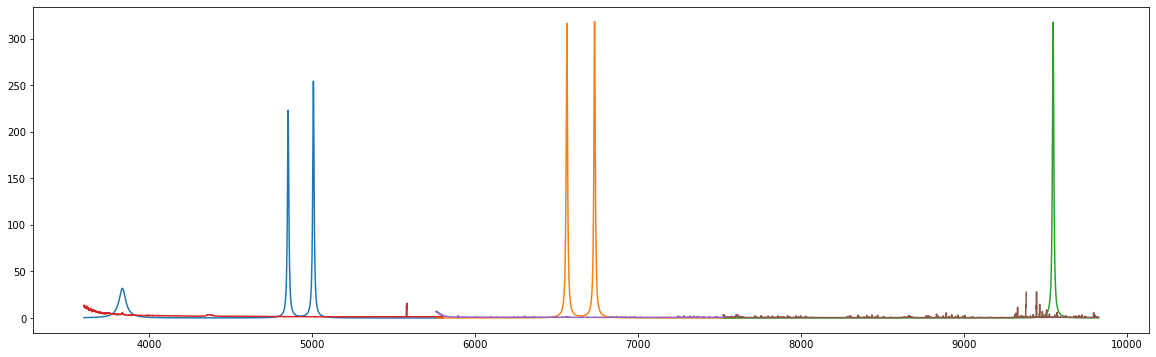

In [67]:
import math
plt.plot(difwave['b'], spec['b'])
# plt.show()
plt.plot(difwave['r'], spec['r'])
# plt.show()
plt.plot(difwave['z'], spec['z'])
# plt.show()
plt.plot(difwave['b'],ivar['b'])
# plt.show()
plt.plot(difwave['r'],ivar['r'])
# plt.show()
plt.plot(difwave['z'],ivar['z'])

In [77]:
perres_filter = perconv_SN(difwave, spec,difivar,mask, ncon = 5)
print(perres_filter)

{'b': 9, 'r': 0, 'z': 0}


In [75]:
linelogic = any(numpy.array(list(perres_filter.values())) >= 9)

In [76]:
print(linelogic)

True


In [68]:
linetable = line_finder(difwave, spec,difivar,mask,0)

/global/u2/d/divij18/timedomain/desidiff/src/ContinuumFitFilter_desidiff.py:91: RuntimeWarning: divide by zero encountered in true_divide
  HBsigma = 1/np.sqrt(HBivar)
/global/u2/d/divij18/timedomain/desidiff/src/ContinuumFitFilter_desidiff.py:100: RuntimeWarning: divide by zero encountered in true_divide
  Hasigma = 1/np.sqrt(Haivar)
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [69]:
print(linetable)

       Line  Wavelength      Height  e_Height         Mean    e_Mean  \
0    Halpha        6562  279.592071  0.296349  6561.856408  0.006766   
1     Hbeta        4861  196.997313       inf  4851.980049       inf   
2    Hgamma        4340    1.000000  1.000000     1.000000  1.000000   
3  HeII4686        4686    7.568739       inf  4935.936692       inf   
4  OIII5007        5007  226.103672       inf  5006.962602       inf   
5      NIII        4100    1.000000  1.000000     1.000000  1.000000   
6       SII        6732  268.478325  0.006766  6732.062675  0.006356   
7  OIII4959        4959   -1.971310       inf  4958.851698       inf   

        Sigma   e_Sigma       Velocity  Chi Square  
0    5.619814  0.006356     603.055570  170.897898  
1    5.082626       inf     737.617501   11.218564  
2    1.000000  1.000000  704145.000000    0.009802  
3  114.156255       inf   16285.167611   11.218564  
4    5.040135       inf     708.810152   11.218564  
5    1.000000  1.000000  704145.0

In [70]:
Hline_score = Hline_filter(linetable)

In [71]:
print(Hline_score)

0
